## Required imports

In [1]:
%matplotlib notebook

import os
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import interact, HBox

import scipy.signal

import pyabf # see: https://github.com/swharden/pyABF

plt.ion()

# These two lines will auto reload imports, in particular bAnalysis
%load_ext autoreload
%autoreload 2

from bAnalysis import bAnalysis

ba = None # global bAnalysis object, used throughout this notebook

## Manually instantiate a bAnalysis object with an .abf file

In [2]:
file = 'data/19114001.abf'
ba = bAnalysis.bAnalysis(file)

# ba is an object of type bAnalysis, see bAnalysis.py for its data members and member functions 

# print some info about it
print(ba)

# get the sweep list
print('ba.sweepList:', ba.sweepList)

# set the sweep (there will be no output)
ba.setSweep(0)

# set a sweep that does not exist
#ba.setSweep(10)

# get dataPointsPerMs
print('ba.dataPointsPerMs:', ba.dataPointsPerMs)

file: data/19114001.abf
ABF (version 2.0.0.0) with 1 channel (mV), sampled at 20.0 kHz, containing 1 sweep, having no tags, with a total length of 1.00 minutes, recorded with protocol "C:\Users\Lab\Documents\Molecular Devices\pCLAMP\Params\claudia\Gapfree AP".
ba.sweepList: [0]
ba.dataPointsPerMs: 20


## Load an abf file

In [3]:
file = 'data/19114001.abf'
ba = bAnalysis.bAnalysis(file)

<IPython.core.display.Javascript object>


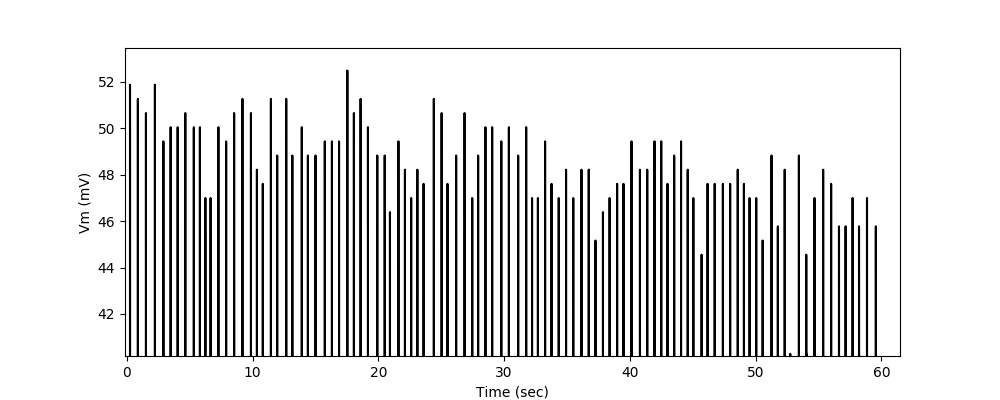

In [4]:
from IPython.display import clear_output

path = 'data'
files = os.listdir(path)

fileList = widgets.Select(
    options=files,
    # rows=10,
    description='fileList',
    disabled=False
)

def loadButton_callback(b):
    file = os.path.join('data', fileList.value)
    
    global ba
    ba = bAnalysis.bAnalysis(file)
    
    #clear_output()
    myAxis.clear()
    ba.plotSpikes(ax=myAxis)
    
loadButton = widgets.Button(
    description='Load',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Load selected file'
)

loadButton.on_click(loadButton_callback)

fig = plt.figure(figsize=(10, 4))
myAxis = fig.add_subplot(1, 1 , 1)

HBox(children=[fileList, loadButton])




## Check the derivative of Vm (dV/dt) to select threshold for spike detection.

<IPython.core.display.Javascript object>


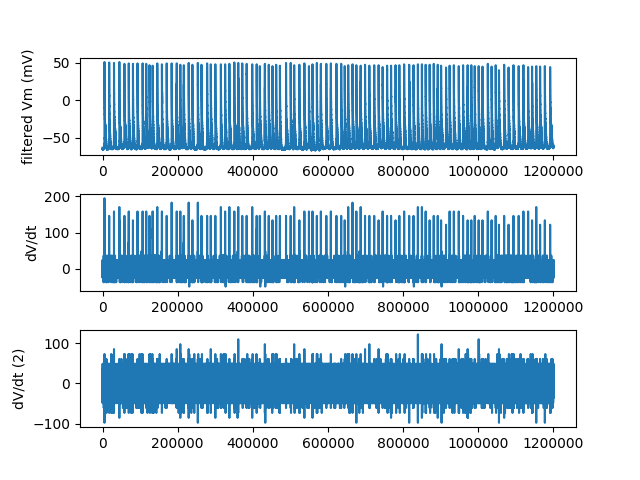

In [5]:
ba.plotDeriv(medianFilter=5)

## Run spike detection with myThreshold and plot results

bAnalysis.spikeDetect() detected  103 spikes


<IPython.core.display.Javascript object>


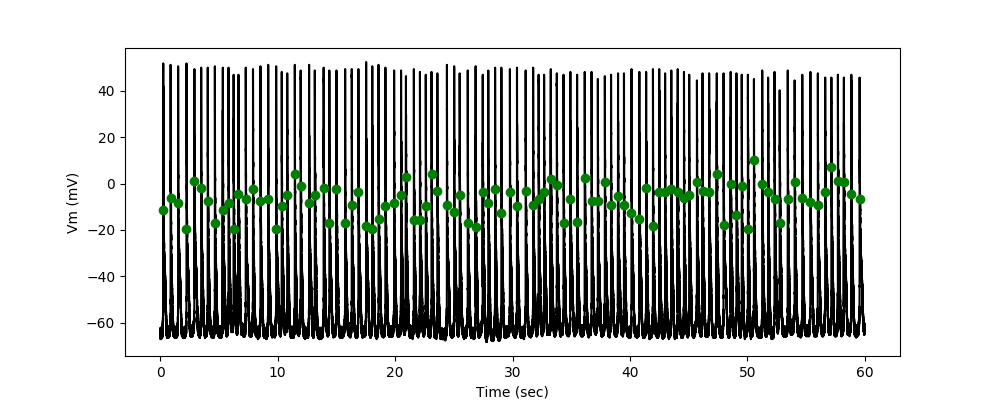

In [6]:
myThreshold = 100
ba.spikeDetect(dVthresholdPos=myThreshold)

# make a matplotlib figure and axis
fig = plt.figure(figsize=(10, 4))
myAxis = fig.add_subplot(1, 1 , 1)

# call a bAnalysis plot function with the axis you just made
ba.plotSpikes(ax=myAxis)

## Make a spike browser

<IPython.core.display.Javascript object>


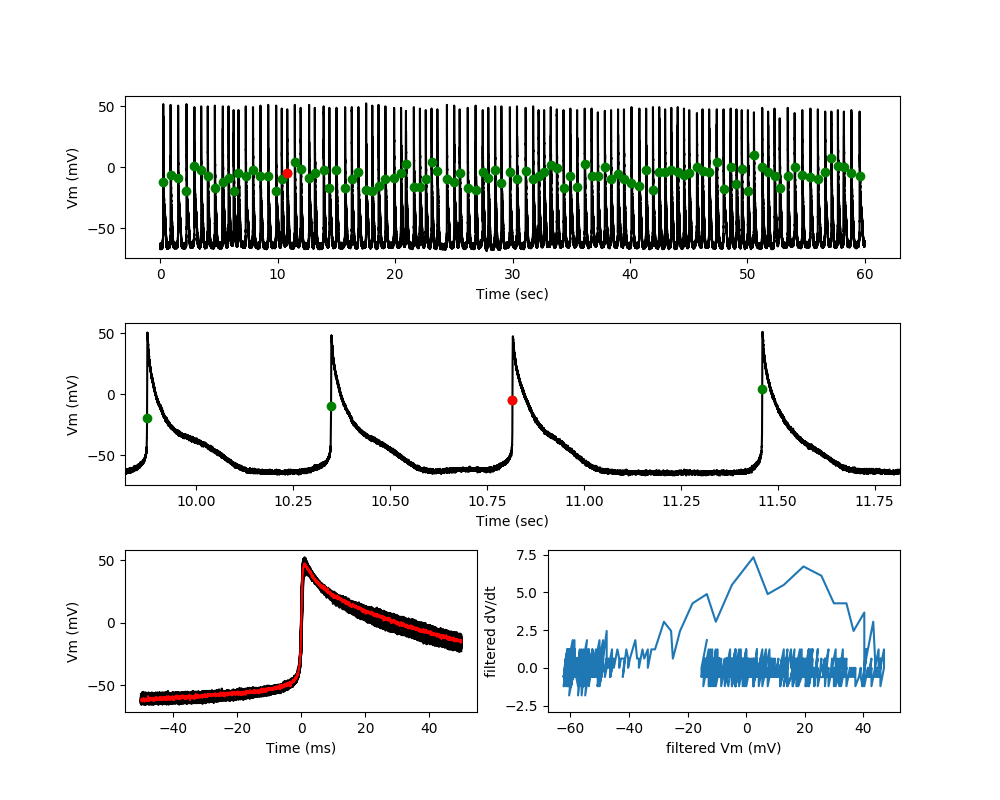

In [7]:

import bAnalysis

currentSpikeNumber = 0

#
# make a figure with subplots and plot it once
grid = plt.GridSpec(3, 2, wspace=0.2, hspace=0.4)

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(grid[0, 0:]) #Vm, entire sweep
ax3 = fig.add_subplot(grid[1, 0:]) #Vm, middle zoom
ax2 = fig.add_subplot(grid[2, 0]) #Vm, spike clip
ax4 = fig.add_subplot(grid[2, 1]) #phase plot

#
# plot vm
line1 = ba.plotSpikes(oneSpikeNumber=currentSpikeNumber, ax=ax1)

#
# plot middle view with intermediate x-axis
line3 = ba.plotSpikes(oneSpikeNumber=currentSpikeNumber, ax=ax3)

#
# plot all clips
line2 = ba.plotClips(oneSpikeNumber=currentSpikeNumber, ax=ax2)

#
# plot one spike phase plot
# filter spike clip
'''filteredClip = scipy.signal.medfilt(ba.spikeClips[currentSpikeNumber],3)
dvdt = np.diff(filteredClip)
# add an initial point so it is the same length as raw data in abf.sweepY
dvdt = np.concatenate(([0],dvdt))
line4, = ax4.plot(filteredClip, dvdt)

ax4.set_ylabel('filtered dV/dt')
ax4.set_xlabel('filtered Vm (mV)')
'''

line4 = ba.plotPhasePlot(oneSpikeNumber=10, ax=ax4)

fig.show()
fig.canvas.draw()

def updatePlot(spikeNumber):
    ''' When called as an ipywidget callback, spikeNumber is a dicitonary !!!'''
    if isinstance(spikeNumber, dict):
        spikeNumber = spikeNumber['new']
    
    global currentSpikeNumber
    currentSpikeNumber = spikeNumber
    
    #
    # plot one spike (red circle)
    line1.set_xdata(ba.abf.sweepX[ba.spikeTimes[spikeNumber]])
    line1.set_ydata(ba.abf.sweepY[ba.spikeTimes[spikeNumber]])

    #
    # plot one spike clip
    if line2 is not None:
        line2.set_ydata(ba.spikeClips[spikeNumber])

    #
    # intermediate (x-axis) plot
    minTime = ba.abf.sweepX[ba.spikeTimes[spikeNumber]] - 1
    maxTime = ba.abf.sweepX[ba.spikeTimes[spikeNumber]] + 1
    ax3.axes.set_xlim(minTime, maxTime)
    line3.set_xdata(ba.abf.sweepX[ba.spikeTimes[spikeNumber]])
    line3.set_ydata(ba.abf.sweepY[ba.spikeTimes[spikeNumber]])
    
    #
    # phase plot
    filteredClip = scipy.signal.medfilt(ba.spikeClips[spikeNumber],3)
    dvdt = np.diff(filteredClip)
    # add an initial point so it is the same length as raw data in abf.sweepY
    dvdt = np.concatenate(([0],dvdt))
    
    line4.set_xdata(filteredClip)
    line4.set_ydata(dvdt)
    
    fig.canvas.draw()
    
mySlider = widgets.IntSlider(
    min=0,
    max=ba.numSpikes-1,
    step=1,
    description='Spike Number',
    value=0,
    continuous_update=False)
mySlider.observe(updatePlot, names='value')

def on_slider_change(change):
    updatePlot(change['new'])
    
def myButton_prev_callback(b):
    global currentSpikeNumber
    currentSpikeNumber -= 1
    if currentSpikeNumber < 0:
        currentSpikeNumber = 0
    mySlider.value = currentSpikeNumber # mySlider will do an update

myButton_prev = widgets.Button(
    description='Previous',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Go to previous spike'
)
myButton_prev.on_click(myButton_prev_callback)


def myButton_next_callback(b):
    global currentSpikeNumber
    currentSpikeNumber += 1
    if currentSpikeNumber > ba.numSpikes - 1:
        currentSpikeNumber = ba.numSpikes - 1
    mySlider.value = currentSpikeNumber # mySlider will do an update

myButton_next = widgets.Button(
    description='Next',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Go to next spike'
)
myButton_next.on_click(myButton_next_callback)


# initial plot
updatePlot(spikeNumber=0)

# display the controls horizontally
HBox(children=[mySlider, myButton_prev, myButton_next])